### Load in

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandorasim as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from tqdm import tqdm
from astropy.io import fits
from pandorasim.utils import plot_nirda_integrations

### Define Functions

In [4]:
##### This is a function for identifying additional targets in the frame. #####
# We can adjust based on target criteria

# The simulator has the function .get_FFIs() that finds the 8 brightest targets in addition to our central target. 
# Eventually, that function may allow us to specify how many targets we want, and we may be able to use that.

def find_target_indices(cat):
    
    # Convert the filtered DataFrame column to a dictionary
    arr = cat['jmag']
    indices = arr.to_dict()
    
    # Sort the dictionary based on values (numbers) and get the first 20 elements
    # NOTE: list out more if you need more targets
    sorted_indices = sorted(indices, key=lambda x: indices[x])[:100] 
    
    good=[]
    for i in range(len(sorted_indices)):
        if cat['ruwe'][i] < 1.2 and cat['jmag'][i] < 15.:
            good.append(sorted_indices[i]) 
    
    return good


# Data Volume

In [5]:
data_rate             = 5 #Mbps
VIS_xpix              = 2048
VIS_ypix              = 2048
regions               = 1
bits_per_pix          = 32
frame_time            = 0.2 #sec
stored_frames_per_int = 1
frames_per_int        = 1
num_int               = 200
compression_fractor   = 3
int_and_reset_time    = frame_time * frames_per_int
bits_per_int          = VIS_xpix * VIS_ypix * regions * bits_per_pix * stored_frames_per_int
bits_per_sec          = bits_per_int / int_and_reset_time
test_time             = num_int * int_and_reset_time
bits_per_sec_comp     = bits_per_sec / compression_fractor
bits_test_total       = bits_per_sec_comp * test_time
Gbits_test_packet     = bits_test_total / 1E9 * 1.1 * 1.25
downlinks             = Gbits_test_packet * 1E9 / (data_rate * 1E6) /60 /8# assuming 8 min passes

print('test time:', test_time, 'seconds')
print(Gbits_test_packet, 'Gbits')
print(downlinks, 'downlinks')

test time: 40.0 seconds
12.303291733333335 Gbits
5.126371555555556 downlinks


### Integration Scheme

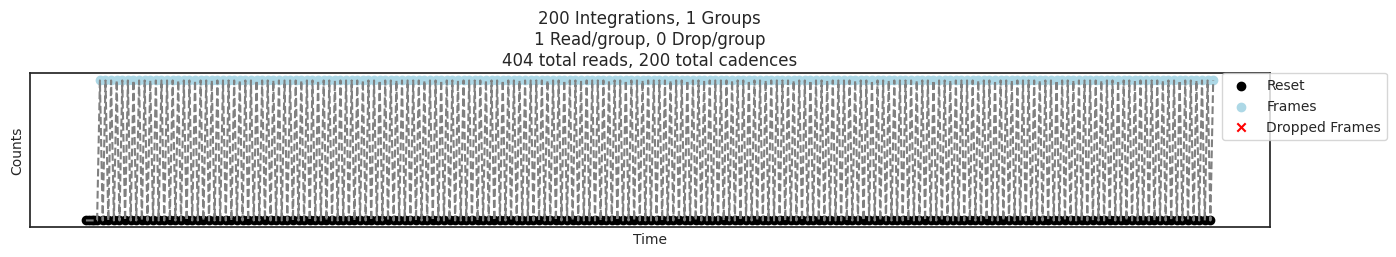

In [7]:
SC_Resets1 = 5
SC_Resets2 = 1
SC_DropFrames1 = 0
SC_DropFrames2 = 0
SC_DropFrames3 = 0
SC_ReadFrames = stored_frames_per_int
SC_Groups = 1
SC_Integrations = num_int

plot_nirda_integrations( ### is there a VISDA function for this? Does there need to be?
    SC_Resets1,
    SC_Resets2,
    SC_DropFrames1,
    SC_DropFrames2,
    SC_DropFrames3,
    SC_ReadFrames,
    SC_Groups,
    SC_Integrations,
);

# Define Targets

In [8]:
##### Primary target #####

target = ps.Target.from_gaia("GJ 436")

### Set Observation Parameters 
# define center based on primary target
ra = target.ra
dec = target.dec
theta = 0*u.deg

# define observation duration
duration = test_time * u.s #adding unit seconds
obstime = Time(target.planets['b']['pl_tranmid'].value - (duration/2).to(u.day).value, format='jd') #arbitrary time

### Initialize Observatory and Point
p = ps.PandoraSim(ra=ra, dec=dec, theta=theta, duration=duration, obstime=obstime)

### Set up Sky Catalog
cat = p.SkyCatalog


In [9]:
##### Find additional target candidates #####

targs = find_target_indices(cat)
print("Indices of possible targets in frame:", targs)

Indices of possible targets in frame: [0, 169, 92, 9, 45, 157, 20, 128, 13, 74, 178, 133, 117, 114, 140, 184, 162, 138, 183, 80, 179, 86, 145, 1, 115, 173, 143, 87, 83, 144, 73, 57, 35, 21, 166, 76, 52, 5, 136, 150, 11, 120]


In [10]:
##### Pick additional targets & print out their info ####

print('Primary Target')
print('j magnitude:', target.jmag)

target2 = 88
print('.')
print('.')
print('Target 2')
print('J magnitude:', cat['jmag'][target2])

target3 = 161
print('.')
print('.')
print('Target 3')
print('J magnitude:', cat['jmag'][target3])


Primary Target
j magnitude: 6.9
.
.
Target 2
J magnitude: 13.522000312805176
.
.
Target 3
J magnitude: 16.839000701904297


# Observation

In [11]:
##### Set up VIS observation #####
visda = p.VISDA

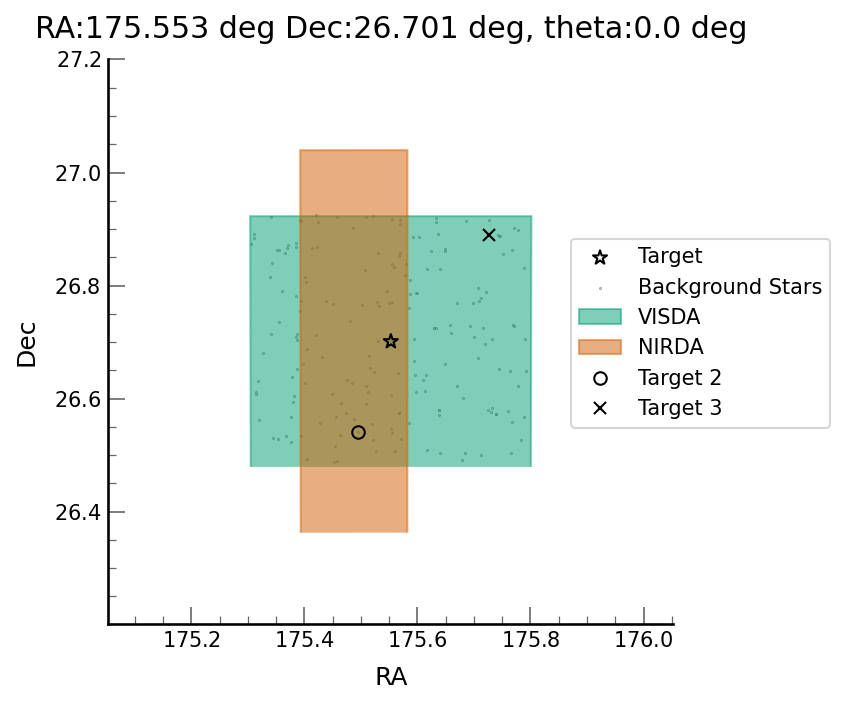

In [12]:
##### Map target on expected location on detector #####

fig = p.plot_footprint();

# Plot secondary targets
plt.plot(cat['ra'][target2], cat['dec'][target2], 'o', label='Target 2', markerfacecolor='none', markeredgecolor='black')
plt.plot(cat['ra'][target3], cat['dec'][target3], 'x', label='Target 3', markerfacecolor='none', markeredgecolor='black')

# Other plotting things
plt.legend(bbox_to_anchor=(0.8, 0.7))

# NOTE: this is showing the full VISDA, and a subarray of NIRDA. We don't need NIRDA for this. 

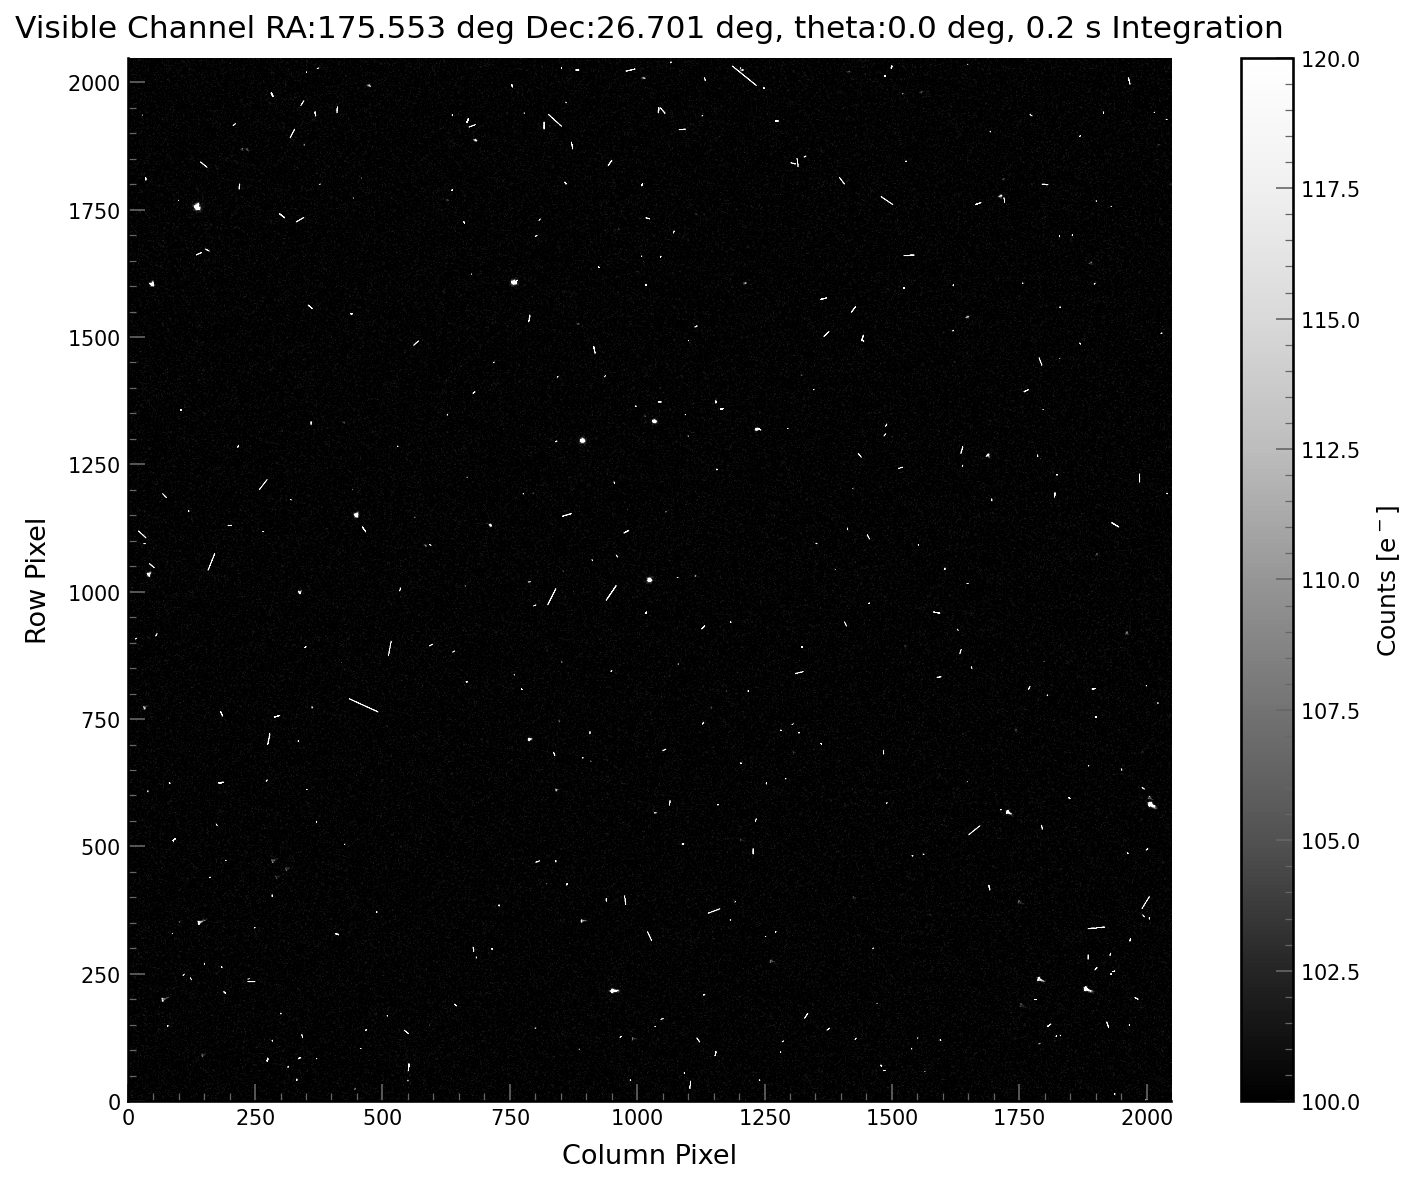

In [15]:
##### Create and plot a simulated observation using plot_FFI #####

# nframes : Number of FFI frames to generate.
# nreads : Number of reads of the detector to coadd in each frame.

p.get_FFIs(nreads=stored_frames_per_int, nframes=num_int, include_noise=True, include_cosmics=True, make_subarrays=False)
p.plot_FFI(nreads=1, include_noise=True, include_cosmics=True, subarrays=False);

### Sim Output Fits File

In [18]:
##### Produce simulated output file of the full frame image #####

# rois=False because we are taking the full frame. We don't need specific regions of interest.

# NOTE: outfile sizes don't match the data volume spreadsheet, but I can answer why once I chat about file formatting details

ffis_outfile = '3_10_ffis.fits'
p.save_visda(outfile=ffis_outfile, rois=False)

In [26]:
##### Show what is in our fits file #####

# Two FITS file extensions: 
#    (1) PRIMARY with some information about the simulated observation 
#    (2) SCIENCE with information about the data

hdul_ffis = fits.open(ffis_outfile)
print(hdul_ffis.info())
print('.')
print('.')
print('.')
print('-- PRIMARY Headers --')
print(hdul_ffis[0].header)
print('.')
print('.')
print('.')
print('-- SCIENCE Headers --')
print(hdul_ffis[1].header)

Filename: 3_10_ffis.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        12   (2048, 2048, 200)   float64   
None
.
.
.
-- PRIMARY Headers --
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  EXTNAME = 'PRIMARY '           / name of extension                              NEXTEND =                    2 / number of standard extensions                  SIMDATA =                    T / simulated data                                 SCIDATA =                    F / science data                                   TELESCOP= 'NASA Pandora'       / telescope                                      INSTRMNT= 'VISDA   '           / ins

# Data Products

### B2:  Generate a table that provides the mapping between the sky and detector positions to quantify field distortions

### B3:  Generate a table that provides the mapping between the sky and detector positions to quantify boresight alignment

In [ ]:
# NOTE: chat with task stakeholders about what they want included in this part of the notebook

In [48]:
##### Print expected target locations from the simulated sky catalogue #####

### Print full catalog:
#cat 

### Print our three targets only:
print('Primary Target')
print('coordinates (ra, dec):', target.ra, ', ', target.dec)
### calculate location on detector
loc_y_1 = cat['vis_row'][0]
loc_x_1 = cat['vis_column'][0] 
print('expected pixel location on detector:', loc_x_1, ', ', loc_y_1) 
print('.')
print('.')
print('.')

print('Target 2')
print('coordinates (ra, dec):', cat['ra'][target2], ', ', cat['dec'][target2])
### calculate location on detector
loc_y_2 = cat['vis_row'][target2]
loc_x_2 = cat['vis_column'][target2] 
print('expected pixel location on detector:', loc_x_2, ', ', loc_y_2) 
print('.')
print('.')
print('.')

print('Target 3')
print('coordinates (ra, dec):', cat['ra'][target3], ', ', cat['dec'][target3])
### calculate location on detector
loc_y_3 = cat['vis_row'][target3] 
loc_x_3 = cat['vis_column'][target3]
print('expected pixel location on detector:', loc_x_3, ', ', loc_y_3) 


Primary Target
coordinates (ra, dec): 175.55296199439047 deg ,  26.701097318817126 deg
expected pixel location on detector: 1023.0000000001905 ,  1022.999848647419
.
.
.
Target 2
coordinates (ra, dec): 175.49488160608536 ,  26.540574610504116
expected pixel location on detector: 1262.7198881559991 ,  274.14768294370856
.
.
.
Target 3
coordinates (ra, dec): 175.7257569381291 ,  26.88924934221842
expected pixel location on detector: 310.8897156257962 ,  1874.0848920737878


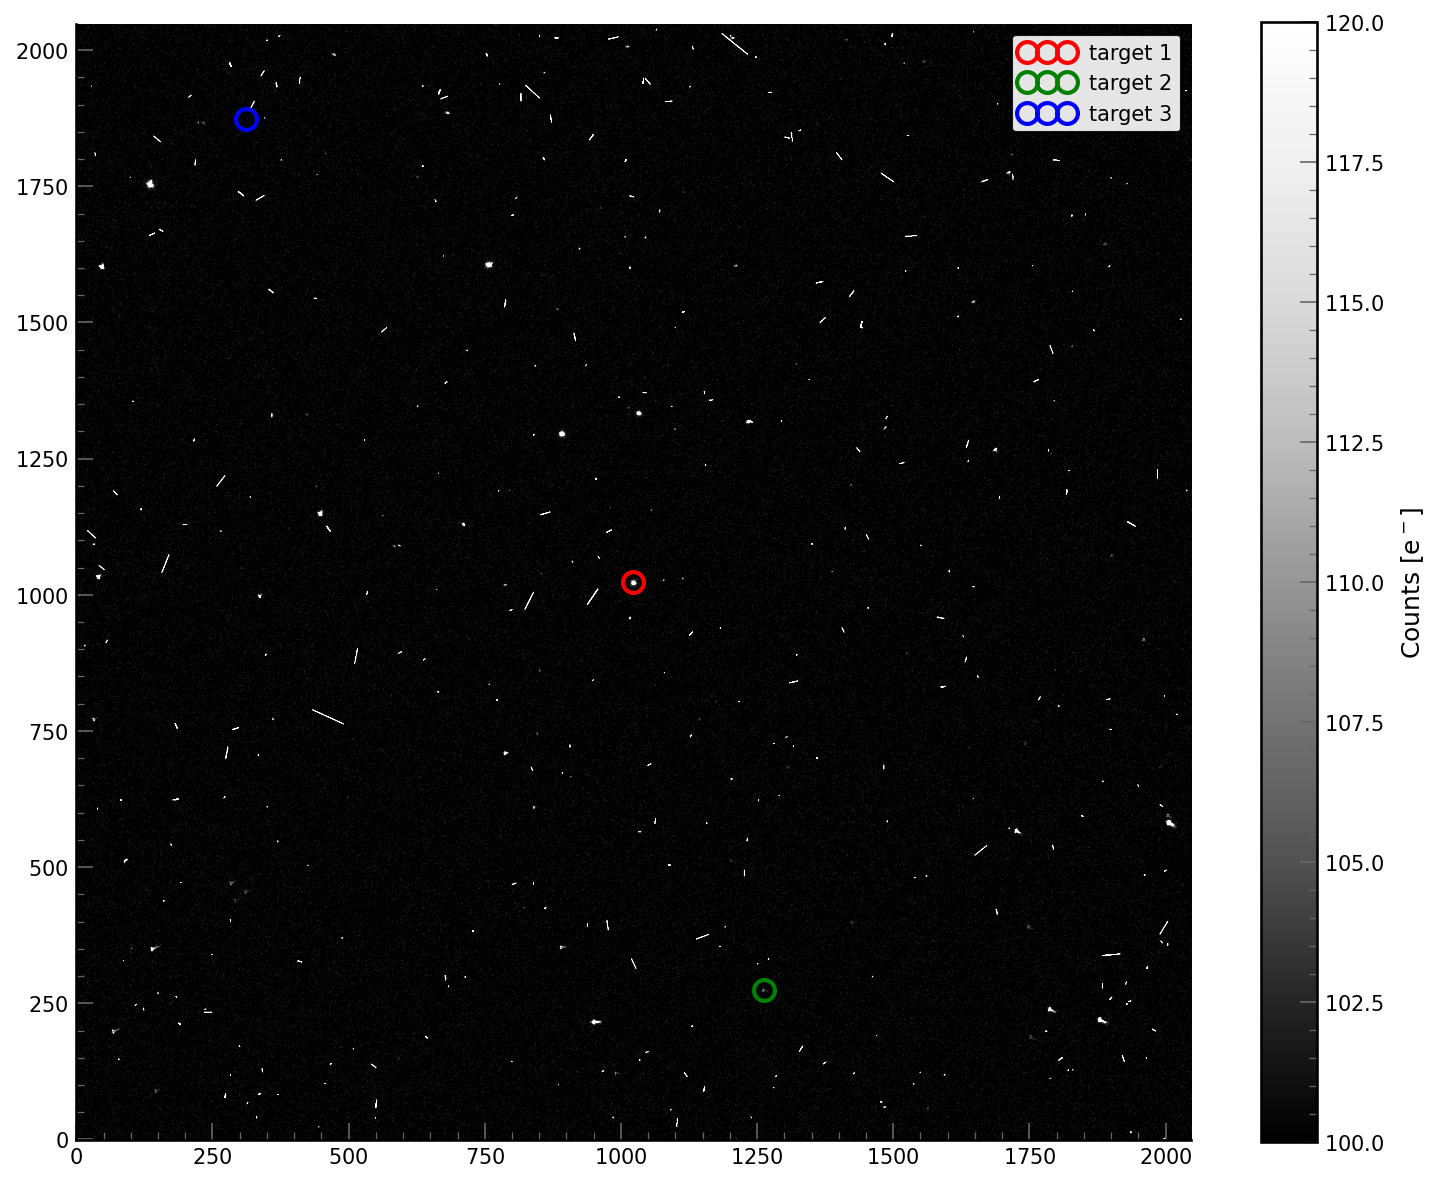

In [51]:
### Plot the image again from the fits file to compare to expected target locations

frame = 0 # specify which integration to plot - can plot different integrations to see any possible jitter

with plt.style.context(ps.PANDORASTYLE):
    vmin = p.VISDA.bias.value
    vmax = p.VISDA.bias.value + 20
    cmap = "Greys_r"
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(
        hdul_ffis[1].data[frame],
        origin="lower",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # **kwargs,
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Counts [e$^-$]", fontsize=12);
    
    plt.plot(loc_x_1, loc_y_1, 'o', markeredgecolor='red', markerfacecolor='none', markeredgewidth=2, markersize=10, label='target 1')
    plt.plot(loc_x_2, loc_y_2, 'o', markeredgecolor='green', markerfacecolor='none', markeredgewidth=2, markersize=10, label='target 2')
    plt.plot(loc_x_3, loc_y_3, 'o', markeredgecolor='blue', markerfacecolor='none', markeredgewidth=2, markersize=10, label='target 3')
    plt.legend()